# Approach 1: Fraktiler

In [19]:
import json

with open('eplusout_hourly_flow_performance.json') as file: 
    data = json.load(file)

Sorter dataen og skær de 10% højeste værdier fra 

In [20]:
## Definer fraktil

k = 100

## Tom liste som skal indeholde den nye maximale luftmængde efter databehandlingen 
flow = []

## Gør følgende for alle 84 zoner
for i in range(84):
    ## Tom liste som skal indeholde alle 8760 flows pr rum
    flow_hourly=[]
    for j in range(len(data['Rows'])): 
        flow_hourly.append(list(data['Rows'][j].values())[0][i])
    
    ## Sorter alle flows
    flow_sorted = sorted(flow_hourly)

    ## Find den k'e værdi og append til flow som er den dimensionerende luftmængde 
    flow.append(flow_sorted[round(8760/100*k-1)])

print(flow)


[2.091513335149267, 0.15991991042673995, 0.029966504633067385, 0.03251078813503034, 0.004876747682158223, 0.004885941773521389, 0.0054009800537423895, 6.94356835084385, 14.349061613976234, 0.8292638152477215, 0.6787453938374923, 1.1394031359038532, 321.76692209657176, 53.31536248619137, 0.0052954000076331316, 0.005279151464827347, 0.004918981553639992, 0.005269858208076354, 0.7831196655247085, 0.529029539803937, 0.16136290188012983, 0.17478654264375681, 0.4664135207702902, 0.4708632105595421, 0.03148973270232951, 0.03077625644941766, 0.009136642351916385, 0.0049177771678404, 0.005373254521947969, 0.005404838441862639, 0.005383826711626022, 0.004888706973259853, 0.005498382804723841, 0.00595776750359912, 0.004562897730001238, 10.696791109997143, 0.09635915273839143, 0.10277681226168169, 1.31197223110445, 2.0337142379522466, 0.5053360077077472, 0.5561273370967437, 0.5055361523260831, 0.5252845407528286, 0.5692539723637524, 0.019489899497772335, 0.005074330511415825, 0.004604518826987249,

Hvis kun brugstidens flow rates ønskes medtaget:

In [3]:
import numpy as np
from datetime import datetime

k = 70

flow = []

start_tid = 8
slut_tid = 17
årstal = 2010

for i in range(84):
    flow_hourly=[]

    for j in range(len(data['Rows'])): 

        key, value = list(data['Rows'][j].items())[0]
        hour = int(key[6:8])
        month = int(key[0:2])
        day = int(key[3:5])

        if month==7 or (month==6 and day>=28) or (month==8 and day<=8):
            pass

        elif start_tid <= hour <= slut_tid:
            dato = datetime.strptime(key, '%m/%d %H:%M:%S').replace(year=årstal)

            if dato.weekday() < 5:
                flow_hourly.append(list(data['Rows'][j].values())[0][i])

    flow_sorted = sorted(flow_hourly)

    flow.append(flow_sorted[round(len(flow_hourly)/100*k-1)])

print(flow)

[0.38499604339109295, 0.028406633968560354, 0.004924276670813431, 0.006269757154071203, 0.0005993215163800302, 0.0006095838152010791, 0.0007647348432448125, 0.05812769519539972, 0.04763023834929089, 0.21261105427781127, 0.2105494923431477, 0.22604722086170886, 0.3139954679382978, 0.3098347330314201, 0.0009166501108080889, 0.0009298627593673323, 0.000684189212845654, 0.0008796152540585065, 0.2107954738928075, 0.21461062745596707, 0.042536034462224995, 0.04439115184878211, 0.20561862171944953, 0.21055076471824657, 0.0038406552737354454, 0.005892606423944433, 0.0009145428893456392, 0.0005647096866742356, 0.0007400773277894117, 0.0008379107692673754, 0.000850494609781846, 0.0006117249610972038, 0.000854457427953058, 0.002178428248368279, 0.0, 0.03252159852330257, 0.03441787659811969, 0.03590253108579025, 0.21829614993915888, 0.2105047497477611, 0.10598167365483514, 0.20799683692388363, 0.21187179150891014, 0.21107565984984822, 0.22385040343322216, 0.003038081217737779, 0.000733945227815348

# Approach 2: Moving average 

In [26]:
import json

with open('eplusout_hourly_flow_performance.json') as file: 
    data = json.load(file)

In [24]:
## Tom liste som skal indeholde den nye dimensionerende luftmængde efter databehandlingen 
flow = []
volumen = np.array([1407, 216, 81, 174, 6, 6, 6, 48, 48, 180, 183, 921, 180, 180, 9, 9, 6, 6, 177, 177, 48, 48, 180, 177, 111, 174, 6, 6, 6, 9, 9, 6, 6, 636, 210, 0, 42, 48, 183, 180, 636, 183, 177, 177, 180, 213, 12, 6, 6, 6, 6, 9, 9, 18, 12, 6, 6, 6, 6, 285, 60, 36, 36, 36, 36, 39, 336, 87, 87, 87, 36, 36, 9, 9, 9, 9, 18, 18, 18, 42, 66, 78, 267, 36])
timestep = 6

## Gør følgende for alle 84 zoner
for i in range(84):
    ## Tom liste som skal indeholde alle 8760 flows pr rum
    flow_hourly = []
    flow_mean = []

    ## Append alle flows for en zone 
    for j in range(len(data['Rows'])):
        x = list(data['Rows'][j].values())[0][i]
        y = volumen[i]/450
        flow_hourly.append(min(x, y))
    
    ## Lav et moving average hvor et gennemsnit tages af de 6 (timestep) tidligere værdier. Kan også bruges som forudsigelse til den næste times behov. 
    for s in range(timestep, len(flow_hourly)):
        flow_mean.append(sum(flow_hourly[s-timestep:s])/timestep)
    
    flow.append(max(flow_mean))

print(flow)

[1.7778858678722609, 0.12973862587156212, 0.022821404758528816, 0.02605584251374404, 0.0038570659686301624, 0.003863848688779922, 0.00394585634953706, 0.10666666666666667, 0.10666666666666667, 0.39999999999999997, 0.40054186567443145, 0.9587233312447939, 0.39999999999999997, 0.39999999999999997, 0.0038997713520835223, 0.0038961486560522584, 0.0038860247716758643, 0.003925556887829634, 0.3933333333333333, 0.3933333333333333, 0.10666666666666667, 0.10666666666666667, 0.38016338900067526, 0.3781890765333629, 0.024717088088082668, 0.02484717790064905, 0.007313067984760704, 0.0038947650117706644, 0.004065621932721247, 0.004100832453531771, 0.004085168962223353, 0.0038455701478321415, 0.004332316577780555, 0.005756195531964763, 0.004108065389819772, 0.0, 0.08124087009843547, 0.08471742659346755, 0.4066666666666667, 0.39999999999999997, 0.4170996798500248, 0.40310929454088634, 0.37384396971640205, 0.37637460609957296, 0.3983088884703079, 0.01548672846643833, 0.0040207738135219565, 0.003690181

# Kun for brugstiden

In [28]:
import numpy as np
from datetime import datetime

flow = []
volumen = np.array([1407, 216, 81, 174, 6, 6, 6, 48, 48, 180, 183, 921, 180, 180, 9, 9, 6, 6, 177, 177, 48, 48, 180, 177, 111, 174, 6, 6, 6, 9, 9, 6, 6, 636, 210, 0, 42, 48, 183, 180, 636, 183, 177, 177, 180, 213, 12, 6, 6, 6, 6, 9, 9, 18, 12, 6, 6, 6, 6, 285, 60, 36, 36, 36, 36, 39, 336, 87, 87, 87, 36, 36, 9, 9, 9, 9, 18, 18, 18, 42, 66, 78, 267, 36])
timestep = 6

start_tid = 8
slut_tid = 17
årstal = 2010

for i in range(84):
    flow_hourly = []
    flow_mean = []

    for j in range(len(data['Rows'])): 

        key, value = list(data['Rows'][j].items())[0]
        hour = int(key[6:8])
        month = int(key[0:2])
        day = int(key[3:5])

        if month==7 or (month==6 and day>=28) or (month==8 and day<=8):
            pass

        elif start_tid <= hour <= slut_tid:
            dato = datetime.strptime(key, '%m/%d %H:%M:%S').replace(year=årstal)

            if dato.weekday() < 5:
                for j in range(len(data['Rows'])):
                    flow_hourly.append(list(data['Rows'][j].values())[0][i])
    
    for s in range(timestep, len(flow_hourly)):
        flow_mean.append(sum(flow_hourly[s-timestep:s])/timestep)
    
    flow.append(max(flow_mean))

print(flow)

KeyboardInterrupt: 

# Zone med index 12 udtaget som test for at plotte 

In [11]:
import numpy as np
from datetime import datetime

flow = []
timestep = 6

start_tid = 8
slut_tid = 17
årstal = 2010

i = 12

flow_hourly = []
flow_mean = []

for j in range(len(data['Rows'])): 

    key, value = list(data['Rows'][j].items())[0]
    hour = int(key[6:8])
    month = int(key[0:2])
    day = int(key[3:5])

    if month==7 or (month==6 and day>=28) or (month==8 and day<=8):
        pass

    elif start_tid <= hour <= slut_tid:
        dato = datetime.strptime(key, '%m/%d %H:%M:%S').replace(year=årstal)

        if dato.weekday() < 5:
            flow_hourly.append(list(data['Rows'][j].values())[0][i])

for s in range(timestep, len(flow_hourly)):
    flow_mean.append(sum(flow_hourly[s-timestep:s])/timestep)

flow.append(max(flow_mean))


[7.0491111793049575]


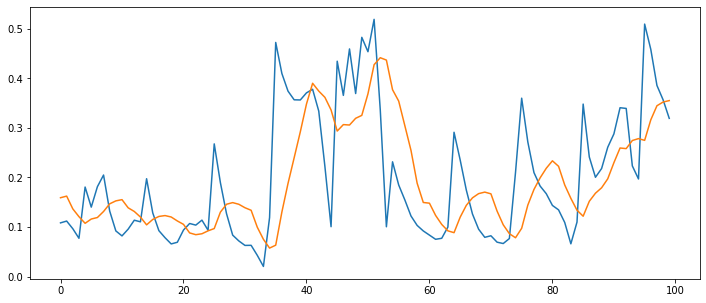

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(range(100), flow_hourly[1406:1506])
plt.plot(range(100), flow_mean[1400:1500])

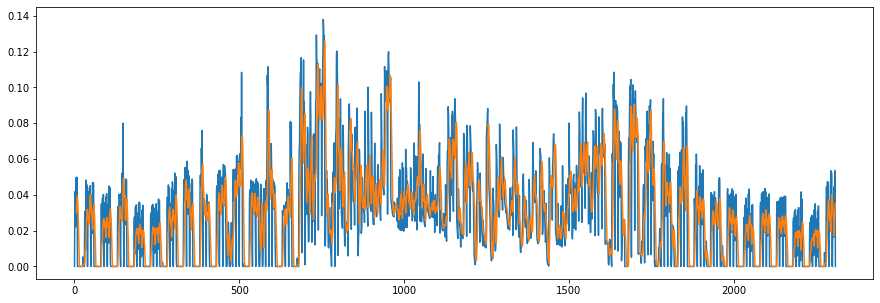

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(range(len(flow_hourly)), flow_hourly)
plt.plot(range(6, len(flow_hourly)), flow_mean)